In [294]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse.linalg 
import scipy
import pandas as pd
import copy
import seaborn as sns

In [286]:
def RCA(Xcp):
    """
    Xcp is a numpy.matrix type
    --|steel|oil|chip|bean|clothes
    --|--|--|--|--|--
    USA|1|1|1|1|0
    China|1|0|0|1|1
    Viet Nam|0|0|0|1|1
    """
    if type(Xcp) is not np.matrix:
        if type(Xcp) is np.array or list:
            Xcp = np.matrix(Xcp)
        else:
            raise ValueError('Xcp must be matrix')
    else:
        pass
    B = Xcp.sum(1)*Xcp.sum(0) 
    Sum = Xcp.sum()
    return Xcp*Sum/B
    
def fliterRCA(R):
    M = R>1
    return M.astype(float)


def Get_eci_pci(M):
    D = np.diag(M.sum(1).T.tolist()[0])
    U = np.diag(M.sum(0).tolist()[0])
    mcp1 = np.linalg.inv(D) * M
    mcp2 = M * np.linalg.inv(U)
    Mcc = mcp1 * mcp2.T
    Mpp = mcp2.T * mcp1
    eigvals, eigvecs = np.linalg.eig(Mpp)
    eigvecs = np.real(eigvecs)
    # Get eigenvector corresponding to second largest eigenvalue
    eig_index = eigvals.argsort()[-2]
    kp = eigvecs[:, eig_index]
    kc = mcp1 * kp
    s1 = np.sign(np.corrcoef(M.sum(1).reshape(-1), kc.reshape(-1))[0, 1])
    eci = s1 * kc
    pci = s1 * kp  
    return eci,pci
def Get_eci_pci_sparse(M):
    d = M.sum(1).T.tolist()[0]
    u = M.sum(0).tolist()[0]
    nd,nu = len(d),len(u)
    D = scipy.sparse.csc_matrix((d, (range(nd), range(nd))),shape=(nd,nd))
    U = scipy.sparse.csc_matrix((u, (range(nu), range(nu))),shape=(nu,nu))
    D1=scipy.sparse.linalg.inv(D)
    U1=scipy.sparse.linalg.inv(U)
    M = sparse.csc_matrix(M)
    mcp1 = D1 * M
    mcp2 = M * U1
    Mcc = mcp1 * mcp2.T
    Mpp = mcp2.T * mcp1
    A=scipy.sparse.csc_matrix(Mpp)
    eigvals, eigvecs = scipy.sparse.linalg.eigs(A, k=2)
    eigvecs = np.real(eigvecs)
    # Get eigenvector corresponding to second largest eigenvalue
    eig_index = eigvals.argsort()[-2]
    kp = eigvecs[:, eig_index]
    kc = mcp1 @ kp
    s1 = np.sign(np.corrcoef(M.sum(1).reshape(-1), kc.reshape(-1))[0, 1])
    eci = s1 * kc
    pci = s1 * kp
    return eci,pci

def Get_z_score(x):
    x=np.array(x)
    std=np.std(x)
    mean=np.mean(x)
    return (x-std)/mean

# example

--|steel|oil|chip|bean|clothes
--|--|--|--|--|--
USA|1|1|1|1|0
China|1|0|0|1|1
Viet Nam|0|0|0|1|1

In [293]:
# example data
product_name = ["steel","oil","chip","bean","clothes"]
country_name = ["USA","China","Viet Nam"]
data = [[1,1,1,1,0],[1,0,0,1,1],[0,0,0,1,1]]
data = np.matrix(data)
R = RCA(data)
M = fliterRCA(R)
D = np.diag(M.sum(1).T.tolist()[0])
U = np.diag(M.sum(0).tolist()[0])
mcp1 = np.linalg.inv(D) * M
mcp2 = M * np.linalg.inv(U)
Mcc = mcp1 * mcp2.T
Mpp = mcp2.T * mcp1
A=scipy.sparse.csc_matrix(Mpp)
eigvals, eigvecs = scipy.sparse.linalg.eigs(A, k=2)
eigvecs = np.real(eigvecs)
# Get eigenvector corresponding to second largest eigenvalue
eig_index = eigvals.argsort()[-2]
kp = eigvecs[:, eig_index]
kc = mcp1 @ kp
s1 = np.sign(np.corrcoef(M.sum(1).reshape(-1), kc.reshape(-1))[0, 1])
eci = s1 * kc
pci = s1 * kp
print(country_name)
print(eci.tolist()[0])
print('='*50)
print(product_name)
print(pci)

['USA', 'China', 'Viet Nam']
[0.3823002058917103, -0.08766501837964581, -0.48578529045792046]
['steel', 'oil', 'chip', 'bean', 'clothes']
[ 0.18527832  0.48081115  0.48081115 -0.61096222 -0.36060836]


# test on PNAS_workerdataframe_v4.pkl

In [14]:
wd1= pd.read_pickle('./PNAS_workerdataframe_v4.pkl')
wd=wd1.dropna(subset=['log_realized_wage','log_requested_wage'])

In [213]:
rqw,rlw=wd['log_requested_wage'],wd['log_realized_wage']

Text(32.125, 0.5, 'log_realized_wage')

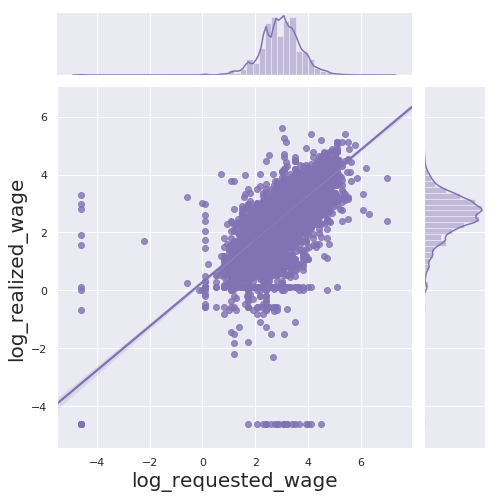

In [359]:

sns.set(style="darkgrid")
tips = sns.load_dataset("tips")
g = sns.jointplot("log_requested_wage", "log_realized_wage", data=wd, kind="reg",color="m", height=7)
plt.xlabel("log_requested_wage",fontsize=20)
plt.ylabel("log_realized_wage",fontsize=20)

In [214]:
#skills-one-hot-codeing
lst=[]
for skills in wd['skills']:
    lst+=skills
lst=list(set(lst))
skill_id=dict(zip(lst,range(len(lst))))
id_skill=dict(zip(range(len(lst)),lst))
data_skill=[[skill_id[s] for s in  p_skills]  for p_skills  in wd['skills']]

In [215]:
from scipy import sparse
row = []
col = []
for i in range(len(data_skill)):
    row += [i for dj in data_skill[i]]
    col += [dj for dj in data_skill[i]]
data_value = [1] * len(row)
m,n = max(row)+1,max(col)+1
c = sparse.csc_matrix((data_value,(row,col)),shape=(m,n))
c = c.toarray()

In [296]:
R = RCA(c)
M = fliterRCA(R)

([<matplotlib.axis.XTick at 0x7f8f19a4b4e0>,
 <a list of 6 Text xticklabel objects>)

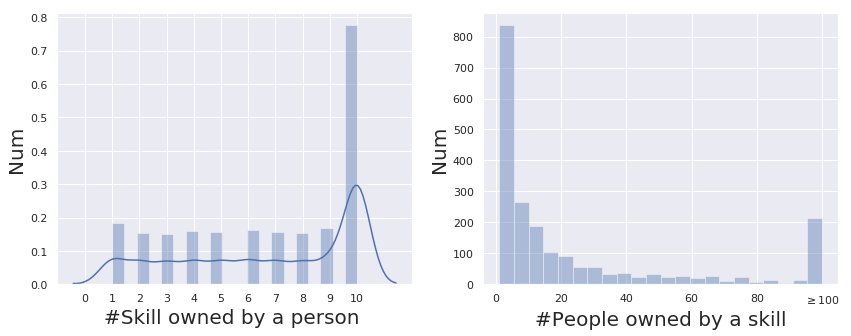

In [346]:
plt.figure(figsize=(14,5))
plt.subplot(121)
sns.distplot([len(s) for s in data_skill],kde=True)
plt.ylabel('Num',fontsize=20)
plt.xlabel('#Skill owned by a person ',fontsize=20)
plt.xticks(range(11))
plt.subplot(122)
sns.distplot([i if i<100 else 100for i in c.sum(0)],kde=False)
#plt.yscale('log')
p20=sum([1 if i<20 else 0 for i in c.sum(0)])/len(c.sum(0))
p40=sum([1 if i<40 else 0 for i in c.sum(0)])/len(c.sum(0))
plt.ylabel('Num',fontsize=20)
plt.xlabel('#People owned by a skill',fontsize=20)
plt.xticks(range(0,101,20),[str(i) if i<100 else "$\geq100$" for i in range(0,101,20)])
#plt.title("distribution of Skill",fontsize=20)

# 超过70%的人掌握10个技能
# 大部分的技能仅有不到5个人掌握
# 超过100人掌握的技能有200个

In [303]:
eci,pci = Get_eci_pci_sparse(np.matrix(c))

Text(0.5, 0, 'eci')

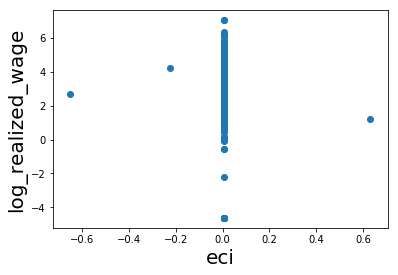

In [305]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.scatter(eci.tolist(),rqw)
plt.ylabel("log_realized_wage",fontsize=20)
plt.xlabel("eci",fontsize=20)